Non-Negative Basis Pursuit DeNoising (APGM)
===========================================

This example demonstrates the solution of a non-negative sparse coding
problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - D \mathbf{x} \|_2^2
  + \lambda \| \mathbf{x} \|_1 + I(\mathbf{x} \geq 0) \;,$$

where $D$ the dictionary, $\mathbf{y}$ the signal to be represented,
$\mathbf{x}$ is the sparse representation, and $I(\mathbf{x} \geq 0)$
is the non-negative indicator.

In this example the problem is solved via Accelerated PGM, using the
proximal averaging method <cite data-cite="yu-2013-better"/> to approximate the
proximal operator of the sum of the $\ell_1$ norm and an indicator
function, while ADMM is used in a
[companion example](sparsecode_nn_admm.rst).

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico

import numpy as np

import scico.numpy as snp
from scico import functional, linop, loss, plot
from scico.optimize.pgm import AcceleratedPGM
from scico.util import device_info
plot.config_notebook_plotting()

Create random dictionary, reference random sparse representation, and
test signal consisting of the synthesis of the reference sparse
representation.

In [2]:
m = 32  # signal size
n = 128  # dictionary size
s = 10  # sparsity level

np.random.seed(1)
D = np.random.randn(m, n).astype(np.float32)
D = D / np.linalg.norm(D, axis=0, keepdims=True)  # normalize dictionary
L0 = max(np.linalg.norm(D, 2) ** 2, 5e1)

xt = np.zeros(n, dtype=np.float32)  # true signal
idx = np.random.randint(low=0, high=n, size=s)  # support of xt
xt[idx] = np.random.rand(s)
y = D @ xt + 5e-2 * np.random.randn(m)  # synthetic signal

xt = snp.array(xt)  # convert to jax array
y = snp.array(y)  # convert to jax array

Set up the forward operator and APGM solver object.

In [3]:
lmbda = 2e-1
A = linop.MatrixOperator(D)
f = loss.SquaredL2Loss(y=y, A=A)
g = functional.ProximalAverage([lmbda * functional.L1Norm(), functional.NonNegativeIndicator()])
maxiter = 250  # number of APGM iterations
solver = AcceleratedPGM(
    f=f, g=g, L0=L0, x0=A.adj(y), maxiter=maxiter, itstat_options={"display": True, "period": 20}
)

Run the solver.

In [4]:
print(f"Solving on {device_info()}\n")
x = solver.solve()

Solving on CPU



Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  1.76e-01  1.835e+01  5.000e+01  1.558e+00


  20  6.34e-01  6.021e-01  5.000e+01  2.050e-02


  40  9.07e-01  4.900e-01  5.000e+01  2.644e-03


  60  1.25e+00  4.763e-01  5.000e+01  1.417e-03


  80  1.53e+00  4.755e-01  5.000e+01  1.393e-03


 100  1.81e+00  4.751e-01  5.000e+01  3.486e-04


 120  2.09e+00  4.749e-01  5.000e+01  1.473e-04


 140  2.37e+00  4.750e-01  5.000e+01  1.638e-04


 160  2.66e+00  4.748e-01  5.000e+01  8.781e-05


 180  2.94e+00  4.748e-01  5.000e+01  7.968e-05


 200  3.23e+00  4.748e-01  5.000e+01  5.149e-05


 220  3.52e+00  4.749e-01  5.000e+01  5.227e-05


 240  3.81e+00  4.749e-01  5.000e+01  3.556e-05


 249  3.94e+00  4.748e-01  5.000e+01  2.624e-05


Plot the recovered coefficients and signal.

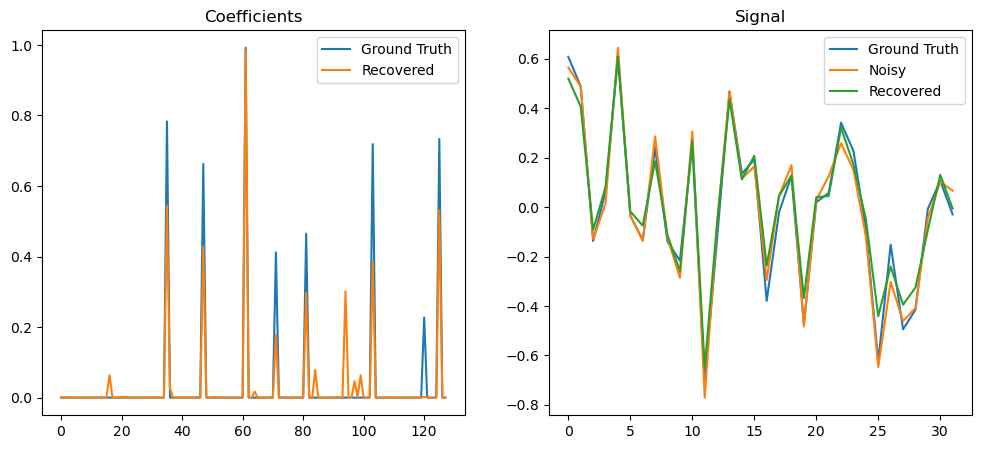

In [5]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    np.vstack((xt, solver.x)).T,
    title="Coefficients",
    lgnd=("Ground Truth", "Recovered"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.vstack((D @ xt, y, D @ solver.x)).T,
    title="Signal",
    lgnd=("Ground Truth", "Noisy", "Recovered"),
    fig=fig,
    ax=ax[1],
)
fig.show()